### VAE as Generative Model

In this part we will draw a comparison between Autoencoders and Variational Autoencoders. We will see how plain AE are good to learn a single latent representation of data but they are not good for generation when we sample from proability distribtion. On the other hand, VAE can map input data to continuous probability distribution. This distribution is normal distribution in case of VAEs. Once we learn this mapping, we can generate new images by simply taking samples from the learnt distribution. 

### Imports

In [ ]:
import os
import random
import numpy as np
from glob import glob
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape
from keras.layers import Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model

# just a little hack so that tensorflow can accpet our custom loss function
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

### Loading, Unzipping and Displaying the Dataset

Mounting your google drive.

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


Unzipping the data file to load it locally in the colab runtime. You can see your unzipped files by clicking the folder icon on left side of your colab.

In [ ]:
# replace this your google drive path of the zip file of dataset provided with this homework
!unzip -o -q "/drive/MyDrive/Dataset_assignment4/ffhq-dataset.zip" -d "/content/data/"

In [ ]:
DATA_FOLDER = '/content/data/'

filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.png')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))

Total number of images : 70000


The dataset is quite large (70000 images) which makes it impossible to load it all at the same time in computer memory. We will use Keras' <i>ImageDataGenerator</i> object and call its member function - <i>flow_from_directory</i> to define the flow of data directly from disk rather than loading the entire dataset into memory. You can also apply various transformations (for augmentation) to the images directly while loading the data (e.g normalizing, rescaling, rotating etc).


You can read more about this in official Keras [documentation](https://keras.io/preprocessing/image/#flow_from_directory).

Below we have setup everything you need for this dataset. You will need to pass <i>data_flow</i> object to <i>fit</i> functions later when training your model.

In [ ]:
INPUT_DIM = (128,128,3) # Image dimension
BATCH_SIZE = 100        # batch of images returned by ImageDataGenerator
Z_DIM = 100            # Dimension of the latent vector (z) [Specify your latent_vector dimension here]

data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(DATA_FOLDER, target_size = INPUT_DIM[:2], 
                                                                   batch_size = BATCH_SIZE, shuffle = True, 
                                                                   class_mode = 'input', subset = 'training')

Found 70000 images belonging to 1 classes.


Utility function to display grid of images.

In [ ]:
def display_image_grid(images, num_rows, num_cols, title_text):

    fig = plt.figure(figsize=(num_cols*3., num_rows*3.), )
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.15)

    for ax, im in zip(grid, images):
        ax.imshow(im)
        ax.axis("off")
    
    plt.suptitle(title_text, fontsize=20)
    plt.show()

Displaying some samples images from the dataset.

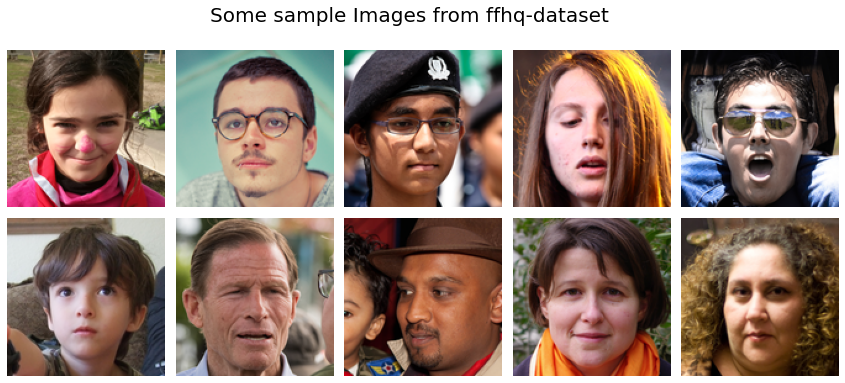

In [ ]:
# a batch of 512 images returned by data generator
sample_images = next(data_flow)[0] 

# only taking 10 of those to display
sample_images = sample_images[:10]

# displaying the images
display_image_grid(sample_images, 2, 5, "Some sample Images from ffhq-dataset")

## AUTOENCODER

#### Encoder

Below you will create the model for your encoder just like the one in Image Completion task (but not necessarily that same). The architecture of the Encoder consists of a stack of convolutional layers followed by a dense (fully connected) layer which outputs a vector of size <i>Z_DIM</i>. The whole image of size 128x128x3 is decoed into this latent space vector of size <i>Z_DIM</i>.


NOTE: You can experiment with the number of feature maps, kernel size, strides and number of conv layer.

In [ ]:
# Code here
inputs = Input(shape=INPUT_DIM)


output = Conv2D(filters=256,kernel_size=3,padding="same",strides=2)(inputs)
output = BatchNormalization()(output)
output = LeakyReLU()(output)
output = Dropout(rate = 0.2)(output)


#         second layer
output = Conv2D(filters=128,kernel_size=3,padding = "same",strides=2)(output)
output = BatchNormalization()(output)
output = LeakyReLU()(output)
output = Dropout(rate = 0.2)(output)

#         third layer
output = Conv2D(filters=64,kernel_size=3,padding = "same",strides=2)(output)
output = BatchNormalization()(output)
output = LeakyReLU()(output)
output = Dropout(rate = 0.2)(output)

#         fourth layer
output = Conv2D(filters=32,kernel_size=3,padding = "same",strides=2)(output)
output = BatchNormalization()(output)
output = LeakyReLU()(output)
output = Dropout(rate = 0.2)(output)
output = Flatten()(output)
output = Dense(Z_DIM)(output)



ae_encoder = Model(inputs = inputs, outputs = output, name = "Encoder")
ae_encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 64, 64, 256)       7168      
_________________________________________________________________
batch_normalization_44 (Batc (None, 64, 64, 256)       1024      
_________________________________________________________________
leaky_re_lu_89 (LeakyReLU)   (None, 64, 64, 256)       0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 32, 32, 128)       295040    
_________________________________________________________________
batch_normalization_45 (Batc (None, 32, 32, 128)       512 

#### Decoder

Just like the encoder you will create the model for the decoder. This model can be the exact mirror of encoder model, but that is not mandatory.

Since the function of the Decoder to reconstruct the image from the latent vector. Therefore, it is necessary to define the decoder so as to increase the size of the activations gradually through the network. This can be achieved through the  [Conv2DTransponse](https://keras.io/layers/convolutional/#conv2dtranspose) layer. This layer produces an output tensor double the size of the input tensor in both height and width.

Again, you can experiment with the number of feature maps, kernel size, strides and number of conv layer.


In [ ]:
# ae_encoder = None
input1  = Input(Z_DIM)
temp = Dense(4*4*32)(input1)
output1 = Reshape((4,4,32))(temp)
output1  = Conv2DTranspose(filters=32,kernel_size=3,padding = "same",strides=2)(output1)
output1 = LeakyReLU()(output1)
output1  = Conv2DTranspose(filters=64,kernel_size=3,padding = "same",strides=2)(output1)
output1 = LeakyReLU()(output1)
output1  = Conv2DTranspose(filters=128,kernel_size=3,padding = "same",strides=2)(output1)
output1 = LeakyReLU()(output1)
output1  = Conv2DTranspose(filters=256,kernel_size=3,padding = "same",strides=2)(output1)
output1 = LeakyReLU()(output1)
output1  = Conv2DTranspose(filters=3,kernel_size=3,padding = "same",activation = "sigmoid",strides=2)(output1)
ae_decoder = Model(inputs = input1, outputs = output1, name = "Decoder")


######################## WRITE YOUR CODE BELOW ########################


########################### END OF YOUR CODE ##########################

ae_decoder.summary()
# tf.keras.utils.plot_model(ae_encoder, show_shapes=True)

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               51712     
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 8, 8, 32)          9248      
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 16, 16, 64)        18496     
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 16, 16, 64)        0   

#### Attaching the Decoder to the Encoder

Finally, here we connect the encoder to the docoder.

In [ ]:

inputf = Input(shape=INPUT_DIM)
tempf = ae_encoder(inputf)
outputf = ae_decoder(tempf)
autoencoder_model = Model(inputs = inputf, outputs = outputf, name = "Autoencoder")

######################## WRITE YOUR CODE BELOW ########################

# The input of the autoencoder will be the same as of encoder


# The output of the autoencoder will be the output of decoder, when passed encoder input


# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.

########################### END OF YOUR CODE ##########################

autoencoder_model.summary()

Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
Encoder (Functional)         (None, 100)               601284    
_________________________________________________________________
Decoder (Functional)         (None, 128, 128, 3)       455395    
Total params: 1,056,679
Trainable params: 1,055,719
Non-trainable params: 960
_________________________________________________________________


### Training the AE

The hyperparameters are the same as given in the Image Completion task.

Also for training, you can use <i>Adam</i> optimizer with the learning rate given below (or you can try out your own).

The number of epochs given are 10, but experiment with that number to know where you can acheive the best results.

In [ ]:
LEARNING_RATE = 0.001
N_EPOCHS = 10

######################## WRITE YOUR CODE BELOW ########################

# compile your model here
autoencoder_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),loss='mean_squared_error',   metrics=['accuracy'])
########################### END OF YOUR CODE ##########################

In [ ]:
SPE = NUM_IMAGES // BATCH_SIZE
print(SPE)

350


Now simply call the <i>fit</i> function of the model with the appropriate paramters.

In [ ]:
######################## WRITE YOUR CODE BELOW ########################
hist = autoencoder_model.fit(x = data_flow, epochs=N_EPOCHS, verbose=2, steps_per_epoch=SPE)

########################### END OF YOUR CODE ##########################

Epoch 1/10
350/350 - 257s - loss: 0.0309 - accuracy: 0.7743
Epoch 2/10
350/350 - 254s - loss: 0.0185 - accuracy: 0.7730
Epoch 3/10
350/350 - 254s - loss: 0.0157 - accuracy: 0.7923
Epoch 4/10
350/350 - 254s - loss: 0.0140 - accuracy: 0.8138
Epoch 5/10
350/350 - 254s - loss: 0.0131 - accuracy: 0.8190
Epoch 6/10
350/350 - 254s - loss: 0.0126 - accuracy: 0.8220
Epoch 7/10
350/350 - 254s - loss: 0.0123 - accuracy: 0.8233
Epoch 8/10
350/350 - 254s - loss: 0.0121 - accuracy: 0.8244
Epoch 9/10
350/350 - 254s - loss: 0.0118 - accuracy: 0.8256
Epoch 10/10
350/350 - 254s - loss: 0.0117 - accuracy: 0.8261


### Reconstruction

Now we will get a batch of images from ImageDataGenerator object and try to reconstruct the images after passing it through our autoencoder.

The first image grid shows the original images and the second grid shows the reconstructed images after passing it through the AE.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


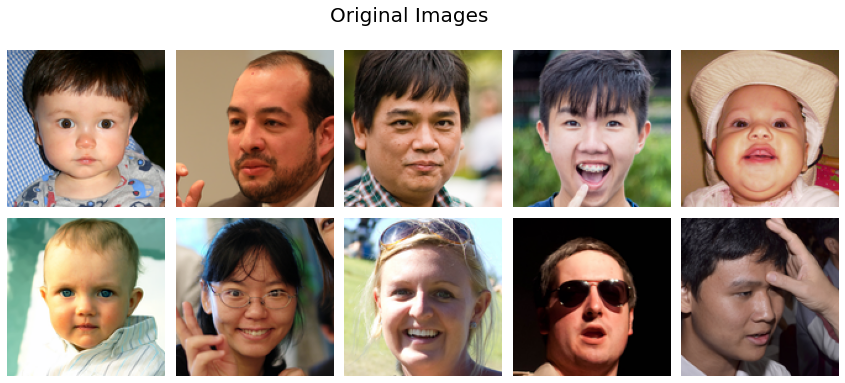

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

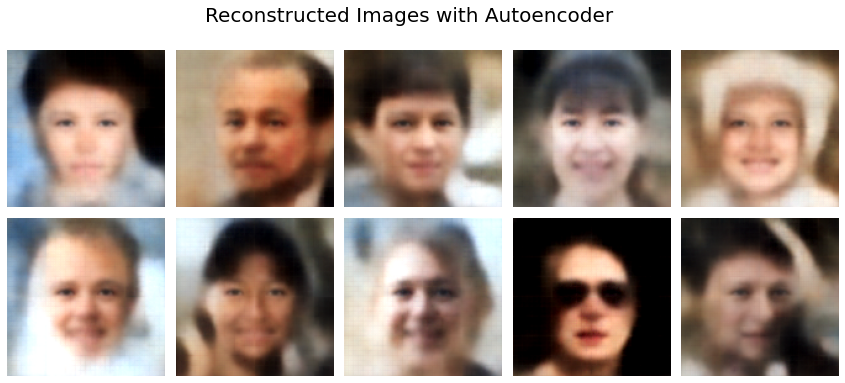

In [ ]:
test_batch = next(data_flow)[0]
test_images = test_batch[:10]

reconst_images = autoencoder_model.predict(test_images)

display_image_grid(test_images, 2, 5, "Original Images")
display_image_grid(reconst_images, 2, 5, "Reconstructed Images with Autoencoder")

<i>NOTE:</i> The reason that you are seeing the reconstructed images as blurry because MSE averages out the differences between individual pixel values. GANs (which you will see in the next assignment) on the other hand produces much sharper results. 

Adding noise before decoding the images

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

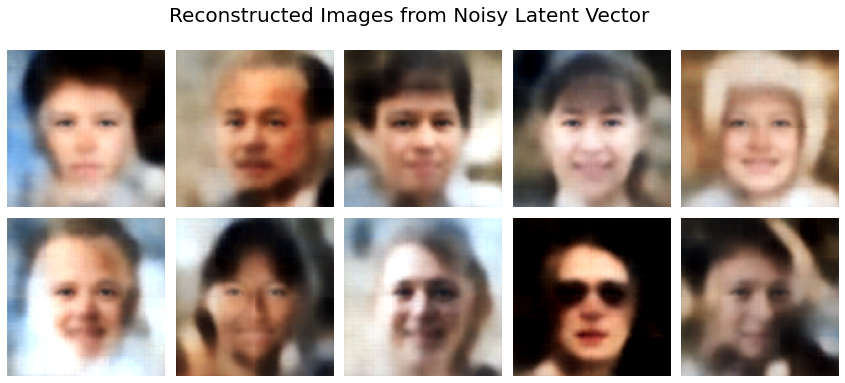

In [ ]:
num_of_images = 10

# encoding our images
encodings = ae_encoder.predict(test_images)

# adding random normal noise to the encoded latent vectors
encodings += np.random.normal(0.0, 1.0, size = (num_of_images, Z_DIM))

# reconstruct from noisy latent vector
reconst_images_noisy = ae_decoder.predict(encodings)

display_image_grid(reconst_images_noisy, 2, 5, "Reconstructed Images from Noisy Latent Vector")

It can be observed that the images are starting to get distorted with a bit of noise added to its encodings. One possible reason could be that the model did not ensure that the space around the encoded values (latent space) was continuous. We will see later how to overcome this with the help of Variational Autoencoder.

### Generation 
Generate images from latent vectors sampled from a standard normal distribution

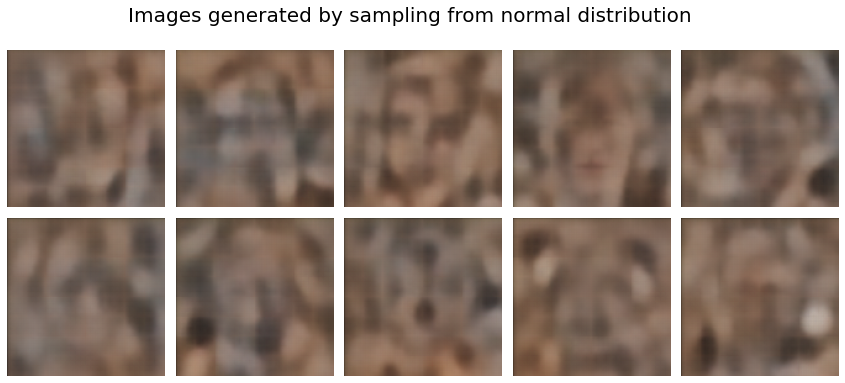

In [ ]:
reconst_images = ae_decoder.predict(np.random.normal(0,1,size=(num_of_images, Z_DIM)))

display_image_grid(reconst_images, 2, 5, "Images generated by sampling from normal distribution")

It is evident that the latent vector sampled from a standard normal distribution can not be used to generate new faces. This shows that the latent vectors generated by the model are not centered/symmetrical around the origin. This also strengthens our inference that the latent space is not continuous.

Since we do not have a definite distribution to sample latent vectors from, it is unclear as to how we can generate new faces. We observed that adding a bit of noise to the latent vector does not produce new faces. We can encode and decode images but that does not meet our objective of learning the joing distribution of data. 

Building on this thought, wouldn't it be great if we could generate new faces from latent vectors sampled from a standard normal distribution? This is essentially what a Variational Autoencoder does.

## VARIATIONAL AUTOENCODER



Variational Autencoders tackle most of the problems discussed above. They are trained to generate new faces from latent vectors sampled from a standard normal distribution. While a Simple Autoencoder learns to map each image to a fixed point in the latent space, the Encoder of a Variational Autoencoder (VAE) maps each image to a z-dimensional standard normal distribution. 



Here is a high level overview of what a Variational Autoencoder does.

<br>
<img src="https://blog.bayeslabs.co/assets/img/vae.jpg"> 
<br><i>Source : blog.bayeslabs.co/2019/06/04/All-you-need-to-know-about-Vae</i>

#### Encoder

The encoder for the Variational AE is little trickier than the simple autoencoder.  While a Simple Autoencoder learns to map each image to a fixed point in the latent space, the Encoder of a Variational Autoencoder (VAE) maps each image to a z-dimensional standard normal distribution. It will loos something like this:

<center>

![picture](https://drive.google.com/uc?export=view&id=1e3iGHK0s83O-RjpbRkO4OWKU52B5kS2I)

</center>

You will need Keras' functional API to make this type of model as this is not a simple feed forward network. You can read and learn more about Function API [here](https://keras.io/guides/functional_api/).

The input to the Decoder, as shown in the image above is a vector sampled from the normal distribution represented by the output of the Encoder - $\mu$ and $\sigma$. This sampling can be done as follows:

<center>
$Z = \mu + \sigma\varepsilon$
</center>

where $\varepsilon$ is a sampled from a multivariate standard normal distribution.


In [ ]:

vae_encoder_input = Input(shape=INPUT_DIM)


outputv = Conv2D(filters=256,kernel_size=3,padding="same",strides=2)(vae_encoder_input)
outputv = LeakyReLU()(outputv)
outputv = Dropout(rate = 0.2)(outputv)


#         second layer
outputv = Conv2D(filters=128,kernel_size=3,padding = "same",strides=2)(outputv)
outputv = LeakyReLU()(outputv)
outputv = Dropout(rate = 0.2)(outputv)

#         third layer
outputv = Conv2D(filters=64,kernel_size=3,padding = "same",strides=2)(outputv)
outputv = LeakyReLU()(outputv)
outputv = Dropout(rate = 0.2)(outputv)

#         fourth layer
outputv = Conv2D(filters=32,kernel_size=3,padding = "same",strides=2)(outputv)
outputv = LeakyReLU()(outputv)
outputv = Dropout(rate = 0.2)(outputv)
outputv = Flatten()(outputv)

mean_mu = Dense(Z_DIM)(outputv)
var = Dense(Z_DIM)(outputv)



######################## WRITE YOUR CODE BELOW ########################

# define your convolution layers here


# define mean and var dense layers outputed by your model

########################### END OF YOUR CODE ##########################

# here is your model outputing mu and var seperately
# now we will take samples from these paramters of distributions
# and these samples will be our latent vector, which 
# can be feed to our decoder


# Defining a function for sampling
# this function takes mean and var vectors and 
def sample_from_distribution(args):
  mean_mu, var = args
  epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
  return mean_mu + K.exp(var/2)*epsilon   
  
# Using a Keras Lambda Layer to include the sampling function as a layer in the model
vae_encoder_output = Lambda(sample_from_distribution, name='Vae_encoder_output')([mean_mu, var])

vae_encoder = Model(vae_encoder_input, vae_encoder_output)
vae_encoder.summary()
# tf.keras.utils.plot_model(vae_encoder, "vae_encoder.png", show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 256)  7168        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 256)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 64, 64, 256)  0           leaky_re_lu[0][0]                
______________________________________________________________________________________________

#### Decoder
Since the Decoder remains the same, you can use the same architecture of the decoder of Autoencoder.

In [ ]:


# ae_encoder = None
vae_decoder_input  = Input(Z_DIM)
tempd = Dense(4*4*32)(vae_decoder_input)
output1d = Reshape((4,4,32))(tempd)
output1d  = Conv2DTranspose(filters=32,kernel_size=3,padding = "same",strides=2)(output1d)
output1d = LeakyReLU()(output1d)
output1d  = Conv2DTranspose(filters=64,kernel_size=3,padding = "same",strides=2)(output1d)
output1d = LeakyReLU()(output1d)
output1d  = Conv2DTranspose(filters=128,kernel_size=3,padding = "same",strides=2)(output1d)
output1d = LeakyReLU()(output1d)
output1d  = Conv2DTranspose(filters=256,kernel_size=3,padding = "same",strides=2)(output1d)
output1d = LeakyReLU()(output1d)
vae_decoder_output  = Conv2DTranspose(filters=3,kernel_size=3,padding = "same",strides=2,activation = "sigmoid")(output1d)

vae_decoder = Model(inputs = vae_decoder_input, outputs = vae_decoder_output, name = "Vae_Decoder")


######################## WRITE YOUR CODE BELOW ########################


########################### END OF YOUR CODE ##########################



vae_decoder.summary()

Model: "Vae_Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               51712     
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 32)          9248      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 64)        18496     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 64)        

#### Attaching the Decoder to the Encoder

Just like in the case of autoencoder, you will connect your encoder with docer and make the final model.


In [ ]:
######################## WRITE YOUR CODE BELOW ########################


# The input to the model will be the image fed to the encoder.


# Output will be the output of the decoder. The term - decoder(encoder_output) 
# combines the model by passing the encoder output to the input of the decoder.


# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.

tempfd = vae_encoder(vae_encoder_input)
outputfd = vae_decoder(tempfd)
vae_model = Model(inputs = vae_encoder_input, outputs = outputfd, name = "VAE")

########################### END OF YOUR CODE ##########################

vae_model.summary()

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
model (Functional)           (None, 100)               804264    
_________________________________________________________________
Vae_Decoder (Functional)     (None, 128, 128, 3)       455395    
Total params: 1,259,659
Trainable params: 1,259,659
Non-trainable params: 0
_________________________________________________________________


### Loss Function

The loss function is a sum of MSE and KL Divergence. MSE error contorls the quality of images (as already seen in the simple autoencoder) while including the KL divergence loss in addition to the MSE loss, the VAE is forced to ensure that the encodings are very similar to a multivariate standard normal distribution. Since a multivariate standard normal distribution has a zero mean, it is centered around the origin. Mapping each image to a standard normal distribution as opposed to a fixed point ensures that the latent space is continuous and the latent vectors are centered around the origin. Here is equation of KL loss, where <b>$\mu$</b> and <b>$\sigma$</b> are the vectors returned by encoder.

<br>
<center>
$D_{KL}[N(\mu,\sigma) \ || \ N(0,1)] = \frac{1}{2}\sum_{i=1}^{z}(1+\log(\sigma_i^2) - \mu_i^2 - \sigma_i^2)$
</center>
</br>

A weight (loss factor) is assigned to the MSE loss. This penalizes the model by loss factor more than KL Diverge to ensure that images produced are of good quality. If we make this loss factor small, the images will be not of good quality. If we make this loss factor large, then our model will simply act as a simple AE.

Hence, this (loss_factor) is also a hyperparamter that you need to take care of. 

Here is the [link](https://keras.io/api/losses/) to Keras documentation on how to create custom loss functions. 

In [ ]:
def total_loss(y_true, y_pred):

    mean_vector = mean_mu   # mean vector outputed by encoder
    var_vector = var        # var vector outputed by encoder
    mse_loss = K.mean(K.square(y_pred-y_true))
    kl_loss =  -0.5*K.sum(1 + K.square(var_vector) - K.square(mean_vector) - K.exp(K.square(var_vector)))

    ######################## WRITE YOUR CODE BELOW ########################

    # calculate mse loss here

    # calculate kl loss here

    ########################### END OF YOUR CODE ##########################

    return LOSS_FACTOR * mse_loss + kl_loss

The loss function is a sum of RMSE and KL Divergence. A weight is assigned to the RMSE loss, known as the loss factor. The loss factor is multiplied with the RMSE loss. If we use a high loss factor, the drawbacks of a Simple Autoencoder start to appear. However, if we use a loss factor too low, the quality of the reconstructed images will be poor. Hence the loss factor is a hyperparameter that needs to be tuned.

In [ ]:
LEARNING_RATE = 0.0001
N_EPOCHS = 10
LOSS_FACTOR = 10000

### Training the VAE


Compile your model below.

In [ ]:
######################## WRITE YOUR CODE BELOW ########################
vae_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),loss=total_loss,   metrics=['accuracy'])
########################### END OF YOUR CODE ##########################

In [ ]:
SPE = NUM_IMAGES // BATCH_SIZE
print(SPE)

700


Now call fit function on your model with appropriate paramters.

In [ ]:
######################## WRITE YOUR CODE BELOW ########################
hist = vae_model.fit(x = data_flow, epochs=N_EPOCHS, verbose=2, steps_per_epoch=SPE)
########################### END OF YOUR CODE ##########################

Epoch 1/10
700/700 - 497s - loss: 698.5921 - accuracy: 0.7845
Epoch 2/10
700/700 - 463s - loss: 652.7802 - accuracy: 0.7868
Epoch 3/10
700/700 - 462s - loss: 629.7939 - accuracy: 0.7870
Epoch 4/10
700/700 - 461s - loss: 623.2183 - accuracy: 0.7870
Epoch 5/10
700/700 - 461s - loss: 618.8481 - accuracy: 0.7871
Epoch 6/10
700/700 - 461s - loss: 615.8236 - accuracy: 0.7871
Epoch 7/10
700/700 - 461s - loss: 613.5340 - accuracy: 0.7871
Epoch 8/10
700/700 - 462s - loss: 611.3533 - accuracy: 0.7871
Epoch 9/10
700/700 - 465s - loss: 609.5584 - accuracy: 0.7871
Epoch 10/10
700/700 - 463s - loss: 607.6862 - accuracy: 0.7871


### Reconstruction
The reconstruction process is the same as that of the Simple Autoencoder.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


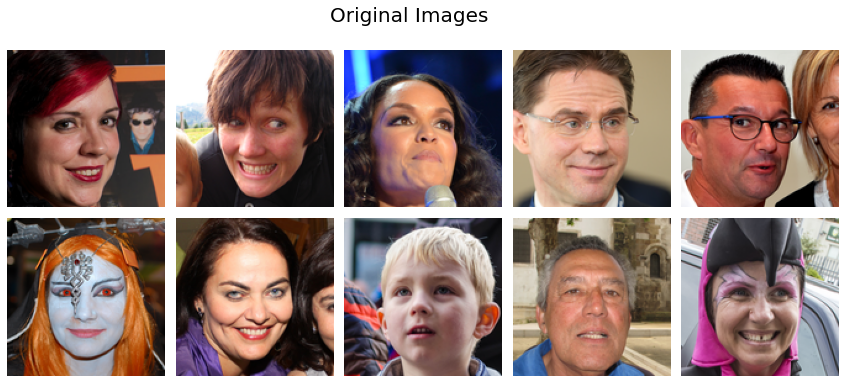

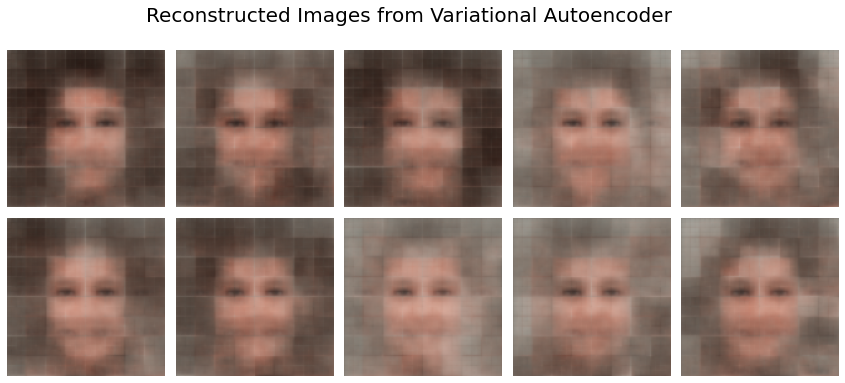

In [ ]:
test_batch = next(data_flow)[0]
test_images = test_batch[:10]

reconst_images = vae_model.predict(test_images)

display_image_grid(test_images, 2, 5, "Original Images")

display_image_grid(reconst_images, 2, 5, "Reconstructed Images from Variational Autoencoder")

###Generation
Generating new faces from random vectors sampled from a standard normal distribution. 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


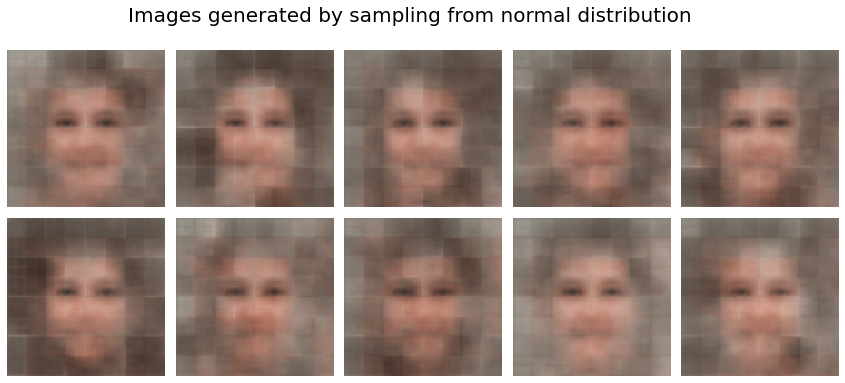

In [ ]:
reconst_images = vae_decoder.predict(np.random.normal(0,1,size=(10, Z_DIM)))

display_image_grid(reconst_images, 2, 5, "Images generated by sampling from normal distribution")

The VAE is evidently capable enough of producing new faces from vectors samped from a standard normal distribution. The fact that a neural network is capable of generating new faces from random noise shows how powerful it is in performing extremely complex mappings!

## REPORT

Report your results for different values of <b>Z_DIM</b>, <b>learning rate</b>, <b>optimizers</b>, <b> encoder and decoder model and Loss Factor</b> and tell us for which configuration you acheived the best results (The best run model should be the last run model in this notebook, showing the results in the cell above).

Answer:Z_dim increased to accuracy and the training time was also reduced, decreasing the value of learning rate my models accuracy increased, encoder and decoder model was the key factor and they affected the accuracy of my model